# Analiz

In [64]:
import pandas as pd
import numpy as np
df = pd.read_csv("sales.csv")
df

,order_id,date,item_name,item_type,item_price,quantity,transaction_amount,transaction_type,received_by,time_of_sale
0,1,07-03-2022,Aalopuri,Fastfood,20,13,260,NaN,Mr.,Night
1,2,8/23/2022,Vadapav,Fastfood,20,15,300,Cash,Mr.,Afternoon
2,3,11/20/2022,Vadapav,Fastfood,20,1,20,Cash,Mr.,Afternoon
3,4,02-03-2023,Sugarcane juice,Beverages,25,6,150,Online,Mr.,Night
4,5,10-02-2022,Sugarcane juice,Beverages,25,8,200,Online,Mr.,Evening
...,...,...,...,...,...,...,...,...,...,...
995,996,3/19/2023,Frankie,Fastfood,50,10,500,NaN,Mrs.,Evening
996,997,9/20/2022,Sandwich,Fastfood,60,7,420,NaN,Mr.,Evening
997,998,1/26/2023,Sandwich,Fastfood,60,13,780,NaN,Mr.,Evening
998,999,8/27/2022,Panipuri,Fastfood,20,5,100,NaN,Mrs.,Afternoon


Veri kümesi 1000 satır ve 10 sütun içermektedir. 
Veri kümesinin her satırı bir siparişe ilişkin bilgileri içerir.

Amacımız, satış verilerini kullanarak, ürünlerin gelecekteki aylık satışlarını tahmin eden bir model geliştirmektir.

Her sütun için veri türünü kontrol edelim:

In [65]:
df.dtypes

order_id               int64
date                  object
item_name             object
item_type             object
item_price             int64
quantity               int64
transaction_amount     int64
transaction_type      object
received_by           object
time_of_sale          object
dtype: object

In [66]:
df.describe()

,order_id,item_price,quantity,transaction_amount
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,33.315000,8.162000,275.230000
std,288.819436,14.921744,4.413075,204.402979
min,1.000000,20.000000,1.000000,20.000000
25%,250.750000,20.000000,4.000000,120.000000
50%,500.500000,25.000000,8.000000,240.000000
75%,750.250000,50.000000,12.000000,360.000000
max,1000.000000,60.000000,15.000000,900.000000


Verilerimizi incelediğimizde, quantity (miktar) değeri için minimum değerin 1 olduğunu tespit ettik. Verimizde 0 değeri bulunmadığı için veri temizleme adımına ihtiyaç duymadık.

Satışlarımızı vakit'e göre inceleyelim;

In [67]:
import plotly.express as px

fig = px.histogram(df, x="item_name", y="quantity", marginal="box", title="Yemek Satışları (Vakit)", color="time_of_sale")
fig.update_layout(bargap=0.1)
fig.show()

Yiyecek ve içecek satışlarını vakit'e göre incelediğimizde satışlar birbirine çok yakındır.

In [68]:
pd.pivot_table(df, columns='time_of_sale', index='item_name', values='quantity', aggfunc='sum')

time_of_sale,Afternoon,Evening,Midnight,Morning,Night
item_name,,,,,
Aalopuri,226,136,223,215,244
Cold coffee,337,235,203,287,299
Frankie,238,240,198,204,270
Panipuri,230,241,278,233,244
Sandwich,164,206,201,234,292
Sugarcane juice,325,283,237,206,227
Vadapav,194,199,235,195,183


# Ön İşleme

Tarih sütunundan yıl, ay ve gün bilgilerini çıkararak yeni sütunlar ekleme

In [69]:
df["date"] = df["date"].str.replace("/", "-")

date = pd.to_datetime(df["date"])

df['year'] = date.dt.year
df[month] = date.dt.month
df[ day ] = date.dt.day

Tarih sütununu modelimiz için Y-M-D formatına çevirme

In [70]:
df["date"] = pd.to_datetime(date, format="Y-M-D")

In [71]:
# from sklearn import preprocessing

# categorical_columns = ['item_name', 'item_type', 'transaction_type', 'received_by', 'time_of_sale']
# # Kategorik verileri one-hot encoding ile dönüştürme
# enc = preprocessing.OneHotEncoder()
# encoded_categorical_columns = enc.fit_transform(df[categorical_columns])
# encoded_feature_names = enc.get_feature_names_out(categorical_columns)
# encoded_categorical_df = pd.DataFrame(encoded_categorical_columns.toarray(), columns=encoded_feature_names)

# df = df.drop(categorical_columns, axis=1)
# df = pd.concat([df, encoded_categorical_df], axis=1)

In [72]:
# from scipy import stats

# # Outlier'ların Z-skoru yöntemi ile belirlenmesi ve işlenmesi
# z_scores = np.abs(stats.zscore(df))
# plt.plot(z_scores)
# df = df[(z_scores < 3).all(axis=1)]
# plt.plot(df)
# len(df) - len(df)

In [73]:
# from sklearn.preprocessing import MinMaxScaler

# numeric_cols = df.select_dtypes(np.number).columns
# scaler = MinMaxScaler().fit(df[numeric_cols])
# df[numeric_cols] = scaler.transform(df[numeric_cols])

In [74]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(24, 12))
# sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
# plt.show()

In [75]:
# Hedef değişken ve açıklayıcı değişkenlerin ayrılması
# X = df.drop(['quantity', 'transaction_amount', 'order_id'], axis=1)
# y = df['quantity']

Tahmin modelimiz için ihtiyacımız olan sütunlar date, year, month, item_name'dir. 
Ürünlerimizi yıl ve ay'a göre satış sayılarını toplayarak gruplayalım:

In [76]:
monthly_sales = df.groupby(['date', 'year', 'month', 'item_name'])['quantity'].sum().reset_index()
monthly_sales

,date,year,month,item_name,quantity
0,2022-04-01,2022,4,Sandwich,7
1,2022-04-02,2022,4,Cold coffee,15
2,2022-04-02,2022,4,Sandwich,15
3,2022-04-03,2022,4,Aalopuri,10
4,2022-04-03,2022,4,Panipuri,11
...,...,...,...,...,...
819,2023-03-26,2023,3,Vadapav,11
820,2023-03-27,2023,3,Panipuri,34
821,2023-03-27,2023,3,Sandwich,6
822,2023-03-29,2023,3,Cold coffee,27


In [77]:
monthly_sales.isna().sum()

date         0
year         0
month        0
item_name    0
quantity     0
dtype: int64

Aylık satış verilerimizi incelediğimizde, eksik değerlerin bulunmadığını tespit ettik. Bu nedenle, eksik verileri tamamlama adımını gerçekleştirmedik. Veri setimiz tam ve eksiksiz olduğu için, doğrudan modelleme sürecine geçtik.

# Model Oluşturma

### SARIMAX

In [105]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sandwich = monthly_sales.query("item_name == 'Sandwich'")
train_sandwich = pd.DataFrame(sandwich[['quantity', 'date']])
train_sandwich.set_index('date', inplace=True)
train_sandwich.rename(columns={'quantity': 'Value'}, inplace=True)

# SARIMA modeli oluşturma ve tahmin yapma
seasonal_period = 12  # 12 aylık sezon

model = SARIMAX(train_sandwich['Value'], order=(5, 2, 0), seasonal_order=(2, 2, 0, seasonal_period))
model_fit = model.fit()

# Tahmin yapma
train_sandwich['Forecast'] = model_fit.predict(start=train_sandwich.index[0], end=train_sandwich.index[-1], dynamic=False)
# Negatif tahminleri sıfırla (veya başka bir uygun dönüşüm uygula)
train_sandwich['Forecast'] = round(train_sandwich['Forecast'].clip(lower=0))

# Sonuçları görüntüleme
print(train_sandwich)

c:\Users\ismai\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\ismai\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



            Value  Forecast
date                       
2022-04-01      7       0.0
2022-04-02     15      12.0
2022-04-03      1      23.0
2022-04-04     29       0.0
2022-04-07     24      57.0
...           ...       ...
2023-03-15     20       0.0
2023-03-18     11      36.0
2023-03-19     28       3.0
2023-03-26      1      30.0
2023-03-27      6      26.0

[109 rows x 2 columns]


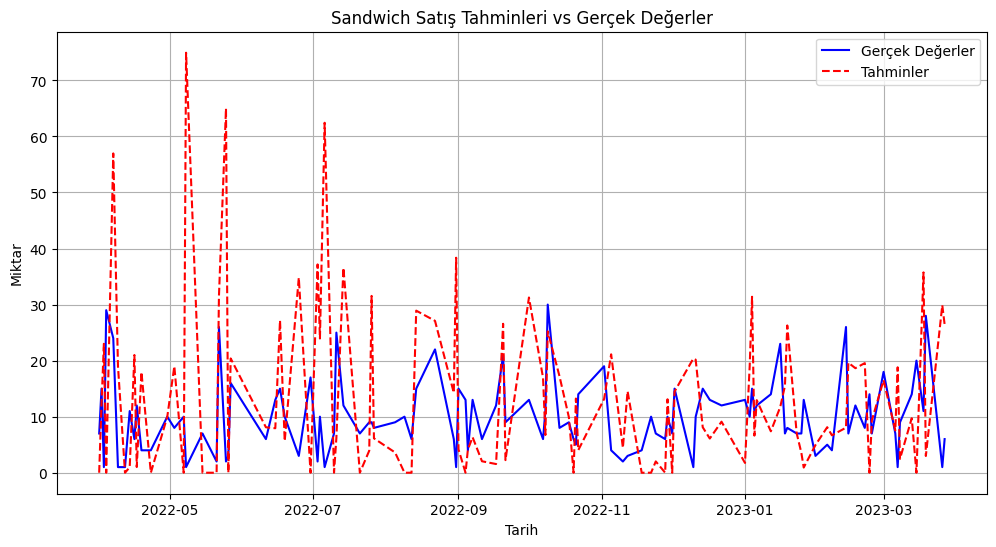

In [79]:
import matplotlib.pyplot as plt

# Gerçek değerler ve tahminler için çizim
plt.figure(figsize=(12, 6))

# Gerçek değerleri çiz
plt.plot(train_sandwich.index, train_sandwich['Value'], label='Gerçek Değerler', color='blue')

# Tahminleri çiz
plt.plot(train_sandwich.index, train_sandwich['Forecast'], label='Tahminler', color='red', linestyle='--')

# Grafik başlığı ve etiketler
plt.title('Sandwich Satış Tahminleri vs Gerçek Değerler')
plt.xlabel('Tarih')
plt.ylabel('Miktar')
plt.legend()

# Grafiği göster
plt.grid(True)
plt.show()


### ARIMA

In [117]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf

cold_coffee= monthly_sales.query("item_name == 'Cold coffee'")
train_cold_coffee = pd.DataFrame(cold_coffee[['quantity', 'date']])
train_cold_coffee.set_index('date', inplace=True)
train_cold_coffee.rename(columns={'quantity': 'Value'}, inplace=True)

# ARIMA modeli oluşturma ve tahmin yapma
# mevsimsel olmayan model (SARIMA yerine ARIMA)


result = adfuller(train_cold_coffee['Value'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
# Model kurma
train_cold_coffee['value_diff'] = train_cold_coffee['Value'].diff().dropna()
model = ARIMA(train_cold_coffee['value_diff'].dropna(), order=(5, 2, 0))  # p, d, q değerlerini belirleyin
model_fit = model.fit()


# Tahmin yapma
train_cold_coffee['Forecast'] = model_fit.predict(start=train_cold_coffee.index[0], end=train_cold_coffee.index[-1], dynamic=False)
# Negatif tahminleri sıfırla (veya başka bir uygun dönüşüm uygula)
train_cold_coffee['Forecast'] = round(train_cold_coffee['Forecast'].clip(lower=0))

# Sonuçları görüntüleme
print(train_cold_coffee)


ADF Statistic: -8.963537411766257
p-value: 8.103114881952616e-15


c:\Users\ismai\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\ismai\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\ismai\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

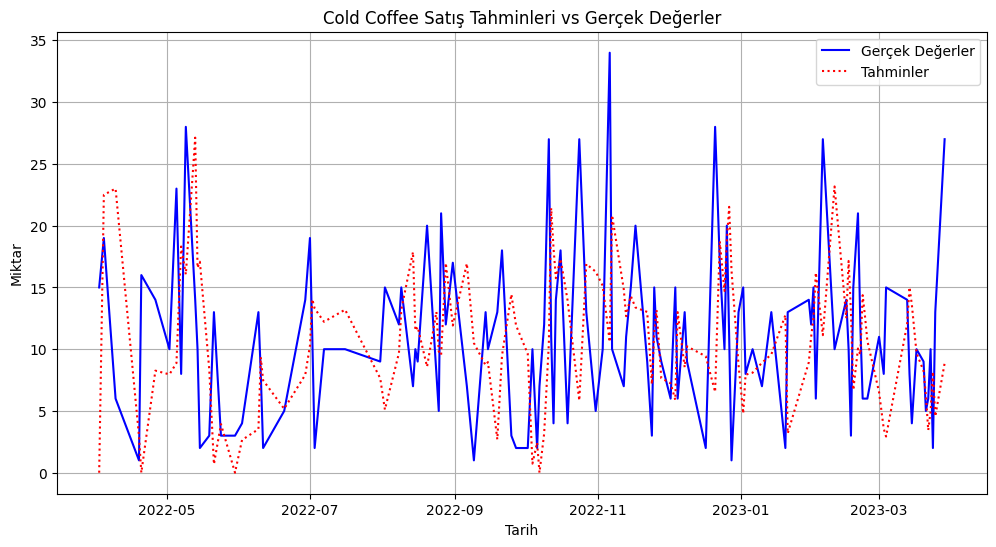

In [81]:
import matplotlib.pyplot as plt

# Gerçek değerler ve tahminler için çizim
plt.figure(figsize=(12, 6))

# Gerçek değerleri çiz
plt.plot(train_cold_coffee.index, train_cold_coffee['Value'], label='Gerçek Değerler', color='blue')

# Tahminleri çiz
plt.plot(train_cold_coffee.index, train_cold_coffee['Forecast'], label='Tahminler', color='red', linestyle=':')

# Grafik başlığı ve etiketler
plt.title('Cold Coffee Satış Tahminleri vs Gerçek Değerler')
plt.xlabel('Tarih')
plt.ylabel('Miktar')
plt.legend()

# Grafiği göster
plt.grid(True)
plt.show()


### Holt-Winters

In [107]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# 'Sandwich' verilerini filtreleme
sandwich = monthly_sales.query("item_name == 'Cold coffee'")
train_sandwich = pd.DataFrame(sandwich[['quantity', 'date']])
train_sandwich['date'] = pd.to_datetime(train_sandwich['date'])
train_sandwich.set_index('date', inplace=True)
train_sandwich.rename(columns={'quantity': 'Value'}, inplace=True)


# Modeli oluşturma ve eğitme
model = ExponentialSmoothing(train_sandwich['Value'], trend='add', seasonal='add', seasonal_periods=5)
model_fit = model.fit(optimized=True)

# Tahmin yapma
forecast = round(model_fit.forecast(steps=5))

from sklearn.metrics import mean_absolute_error
y_true = train_sandwich['Value'][-5:]  # Son 5 gerçek değer
y_pred = forecast
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae}************")

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_true, y_pred)
print(f"MSE: {mse}-------------")

rmse = np.sqrt(mse)
print(f"RMSE: {rmse}*******")
mape = np.mean(np.abs((y_true - forecast) / y_true)) * 100
print(f"mape: {mape}*******")
print(f"y_true: {y_true}*******")
print(f"forecast: {forecast}*******")

# # Gerçek ve tahmin edilen değerleri çizme
# plt.figure(figsize=(10, 6))
# plt.plot(train_sandwich.index, train_sandwich['Value'], label='Gerçek', marker='o')
# forecast_index = pd.date_range(start=train_sandwich.index[-1], periods=5, freq='M')
# plt.plot(forecast_index, forecast, label='Tahmin', marker='o')
# plt.xlabel('Tarih')
# plt.ylabel('Miktar')
# plt.title('Sandwich Satışları - Gerçek ve Tahmin Edilen Değerler')
# plt.legend()
# plt.show()

c:\Users\ismai\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



MAE: 7.2************
MSE: 78.8-------------
RMSE: 8.87693640846886*******
mape: nan*******
y_true: date
2023-03-22     6
2023-03-23    10
2023-03-24     2
2023-03-25    13
2023-03-29    27
Name: Value, dtype: int64*******
forecast: 124    14.0
125    11.0
126    10.0
127    10.0
128    11.0
dtype: float64*******


c:\Users\ismai\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\ismai\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

C:\Users\ismai\AppData\Local\Temp\ipykernel_3668\2998616302.py:29: RuntimeWarning:

'<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.

